In [1]:
using LinearAlgebra
using SparseArrays

In [73]:
#wyliczanie indeksu = i + (j-1)*NX + (k-1)*NX*NY
NX = 4
NY = 3
NZ = 2
Δx = 0.05
Δy = 0.05
Δz = 0.05
idx2 = 1/Δx
idy2 = 1/Δy
idz2 = 1/Δz

d = zeros(NX,NY,NZ)

function build_matrix(ϕ)
    A = spzeros(length(ϕ), length(ϕ))
    nx, ny, nz = size(ϕ)
    for k = 1:size(ϕ)[3], j = 1:size(ϕ)[2], i = 1:size(ϕ)[1]
        u = i + (j-1)*nx + (k-1)*nx*ny
        #println(i, " ", j, " ", k)
        #println(u)
        
        A[u,u] = -2.0*(idx2 + idy2 + idz2)
        if i == 1                  # i-1
            A[u,u+nx-1] = idx2
        else
            A[u,u-1] = idx2
        end
        if i == nx                 # i+1
            A[u,u-nx+1] = idx2      
        else
            A[u,u+1] = idx2
        end
        if j == 1                  # j-1
            A[u,u+(ny-1)*nx] = idy2   
        else
            A[u,u-nx] = idy2
        end
        if j == ny                  # j+1
            A[u,u-(ny-1)*nx] = idy2 
        else
            A[u,u+nx] = idy2
        end
        if k == 1                  # k-1
            A[u,u+(nz-1)*nx*ny] = idz2   
        else
            A[u,u-nx*ny] = idz2
        end
        if k == nz                  # k+1
            A[u,u-(nz-1)*nx*ny] = idz2
        else
            A[u,u+nx*ny] = idz2
        end
    end
    return A
end

build_matrix (generic function with 1 method)

In [17]:
function preconditioner_jacobi(A)
    return Diagonal([1/A[i, i] for i in 1:size(A)[1]])
end

preconditioner_jacobi (generic function with 1 method)

In [44]:
norm(x) = sqrt(sum(x.^2))

function PCG(A, b, x, tol)
    conv = false
    M = preconditioner_jacobi(A)
    g = A*x - b
    s = M*g
    d = -s

    L2 = norm(g)
    while L2 > tol
        z = A*d
        α = dot(g,s)
        β = dot(d,z)
        x = x + (α/β)*d
        g = g + (α/β)*z
        s = M*g
        β = α
        α = dot(g,s)
        d = (α/β)*d - s
        
        L2 = norm(g)
        if L2 < tol
            conv = true
            break
        end
    end

    if conv == false
        println("PCG failed to converge, L2 = $(L2)")
    end
    return x
end

PCG (generic function with 1 method)

In [1]:
include("../pic3d.jl")
using .PIC3D
using PyPlot
using LinearAlgebra
using PyCall
anim =  pyimport("matplotlib.animation");
using BenchmarkTools

In [2]:
function generate_particles!(NP, d)
    num = d / (2*NP / (PIC3D.XL*PIC3D.YL*PIC3D.ZL))
    println(num)
    electrons = PIC3D.Species(q=PIC3D.q_e*num, m=PIC3D.m_e*num)
    ions = PIC3D.Species(q=-PIC3D.q_e*num, m=PIC3D.m_e*num*2000)
    @inbounds for i = 1:NP
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
        
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [-5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
    end

    return electrons, ions
end

generate_particles! (generic function with 1 method)

In [3]:
function compute_EK_particles(electrons, ions)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    # @inbounds for i in eachindex(ions.v)
    #     ek += ions.m*dot(ions.v[i], ions.v[i])
    # end
    ek = 0.5*ek
    return ek
end

function compute_EK_particles2(electrons, ions, NP, d)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += electrons.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek*(d / (2*NP / (PIC3D.Δx*PIC3D.Δy*PIC3D.Δz)))
    return ek
end

function compute_EP_field()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.Ex[i,j,k]^2 + PIC3D.Ey[i,j,k]^2 + PIC3D.Ez[i,j,k]^2
    end
    ep = 0.5 * PIC3D.ε_0 * ep * PIC3D.Δx*PIC3D.Δy*PIC3D.Δz
    return ep
end


function compute_EP_potential()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.ρ[i,j,k] * PIC3D.ϕ[i,j,k]
    end
    ep = 0.5* PIC3D.ε_0 *ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [85]:
#dirichlet
#A COND (L2): 178.06427461086167
#A COND (max z col): 294.96232471011115
#periodic
#A COND (L2): 4.2680503611222944e17
#A COND (max z col): 1.6376725917711344e19

#-5e-12

NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

timesteps = 10

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

562500.0000000001
1
GS failed to converge, L2 = 0.0033309752786442434
[-140.64061103494774 -140.62820196460467 -140.5790798407926; -140.65875387631013 -140.60115951346108 -140.55274610224168; -140.61329617328235 -140.55462025033668 -140.51981230357327]
2
GS failed to converge, L2 = 0.0033300273833742743
[-140.6022463766956 -140.58898638171345 -140.53872450072788; -140.6211755030557 -140.56202029799107 -140.51234848288183; -140.57448006527702 -140.51489237968906 -140.47957309828544]
3
GS failed to converge, L2 = 0.003348344718919533
[-141.37101507389872 -141.35820605696642 -141.30824103127432; -141.39072812253318 -141.33130253527455 -141.28181001768854; -141.3437057725233 -141.28404158385376 -141.24923907503364]
4
GS failed to converge, L2 = 0.0033575853997715598
[-141.7599375969582 -141.74767994644023 -141.6978538163906; -141.7800431594565 -141.72057050452736 -141.67123334747558; -141.73276381249562 -141.67306807801805 -141.63865340708432]
5
GS failed to converge, L2 = 0.00335766172954

In [4]:
#dirichlet
#A COND (L2): 178.06427461086167
#A COND (max z col): 294.96232471011115
#periodic
#A COND (L2): 4.2680503611222944e17
#A COND (max z col): 1.6376725917711344e19

#-5e-12

NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

timesteps = 10

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    #println(i)
    PIC3D.timestep_FFT!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
    end
    push!(historyxx, [[ex...] for ex in electrons.x])
    push!(historyvel, [[ev...] for ev in electrons.v])
    
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

562500.0000000001
[-120.18675625742507 -115.52466510267357 -96.15500208912991; -124.20578786178928 -106.66478067651664 -87.11112567872382; -110.5518632467989 -89.28725289426465 -74.21327006450292]
[-120.3100637049468 -115.27050850164939 -95.58277205242655; -124.4238170709503 -106.41387258505353 -86.48524311079997; -110.42213040974278 -88.89066891259577 -73.62648802341289]
[-118.10206948306607 -113.31428720514907 -93.97328638372471; -122.26332543570805 -104.43188709235694 -84.77438081048601; -108.22827975770015 -86.90377703080952 -71.94326834187365]
[-115.80883897519773 -111.30488415433112 -92.45146252373799; -119.39178166404949 -101.9533922834515 -82.80597563443668; -104.57994336135583 -83.75162259613901 -69.51087015827238]
[-112.9509703860856 -108.98134700539649 -90.81881962075545; -116.4178542969687 -99.60890463026549 -81.01741906448935; -101.74949960116547 -81.50202776846719 -67.74656004671054]
[-110.01215350593644 -106.47508771943876 -89.03277529625913; -113.29026299388377 -97.0782

In [1]:
[0:16÷2-1; -16÷2:-1]  * 2π * 1/16

16-element Vector{Float64}:
  0.0
  0.39269908169872414
  0.7853981633974483
  1.1780972450961724
  1.5707963267948966
  1.9634954084936207
  2.356194490192345
  2.748893571891069
 -3.141592653589793
 -2.748893571891069
 -2.356194490192345
 -1.9634954084936207
 -1.5707963267948966
 -1.1780972450961724
 -0.7853981633974483
 -0.39269908169872414

In [23]:
using SparseArrays
using LinearAlgebra

function build_coefficient_matrix(nx, ny, nz, Δx, Δy, Δz)
    N = nx * ny * nz
    A = spzeros(N, N)
    idx2 = 1/Δx^2
    idy2 = 1/Δy^2
    idz2 = 1/Δz^2

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny

        A[u, u] = -2.0 * (idx2 + idy2 + idz2)
        if i > 1
            A[u, u-1] = idx2
        end
        if i < nx
            A[u, u+1] = idx2
        end
        if j > 1
            A[u, u-nx] = idy2
        end
        if j < ny
            A[u, u+nx] = idy2
        end
        if k > 1
            A[u, u-nx*ny] = idz2
        end
        if k < nz
            A[u, u+nx*ny] = idz2
        end
    end
    return A
end
function build_coefficient_matrix_pbc(nx, ny, nz, Δx, Δy, Δz)
    N = nx * ny * nz
    A = spzeros(N, N)
    idx2 = 1 / Δx^2
    idy2 = 1 / Δy^2
    idz2 = 1 / Δz^2

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j - 1) * nx + (k - 1) * nx * ny

        A[u, u] = -2.0 * (idx2 + idy2 + idz2)

        # Warunki brzegowe periodyczne w kierunku x
        if i == 1
            A[u, u + nx - 1] = idx2
        else
            A[u, u - 1] = idx2
        end

        if i == nx
            A[u, u - nx + 1] = idx2
        else
            A[u, u + 1] = idx2
        end

        # Warunki brzegowe periodyczne w kierunku y
        if j == 1
            A[u, u + (ny - 1) * nx] = idy2
        else
            A[u, u - nx] = idy2
        end

        if j == ny
            A[u, u - (ny - 1) * nx] = idy2
        else
            A[u, u + nx] = idy2
        end

        # Warunki brzegowe periodyczne w kierunku z
        if k == 1
            A[u, u + (nz - 1) * nx * ny] = idz2
        else
            A[u, u - nx * ny] = idz2
        end

        if k == nz
            A[u, u - (nz - 1) * nx * ny] = idz2
        else
            A[u, u + nx * ny] = idz2
        end
    end

    return A
end


function build_b_vector(ρ, ε₀)
    nx, ny, nz = size(ρ)
    b = zeros(Float64, nx * ny * nz)

    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny
        b[u] = -ρ[i,j,k] / ε₀
    end
    return b
end


function jacobi_preconditioner(A)
    return Diagonal([1/A[i,i] for i in 1:size(A, 1)])
end


function apply_solution_to_ϕ!(ϕ, x)
    nx, ny, nz = size(ϕ)
    for k in 1:nz, j in 1:ny, i in 1:nx
        u = i + (j-1)*nx + (k-1)*nx*ny
        ϕ[i,j,k] = x[u]
    end
end

normL2(x) = sqrt(sum(x.^2))

function compute_potential_PCG!(ϕ, ρ, Δx, Δy, Δz, ε₀, tolerance, max_it)
    nx, ny, nz = size(ϕ)
    A = build_coefficient_matrix_pbc(nx, ny, nz, Δx, Δy, Δz)
    b = build_b_vector(ρ, ε₀)
    M = jacobi_preconditioner(A)
    x = zeros(Float64, length(b))

    g = A * x - b
    s = M * g
    d = -s

    L2 = normL2(g)
    it = 1

    while L2 > tolerance && it < max_it
        z = A * d
        α = dot(g, s) / dot(d, z)
        x = x + α * d
        g = g + α * z
        s = M * g
        β = dot(g, s) / (α * dot(d, z))
        d = -s + β * d

        L2 = normL2(g)
        it += 1
    end
    println("L2 = $(L2)")

    if L2 > tolerance
        println("PCG failed to converge, L2 = $L2")
    end

    apply_solution_to_ϕ!(ϕ, x)
end

nx, ny, nz = 10, 10, 10
ϕ = zeros(Float64, nx, ny, nz)
ρ = rand(Float64, nx, ny, nz)
Δx, Δy, Δz = 1.0, 1.0, 1.0
ε₀ = 8.854e-12 
tolerance = 1e-6
max_it = 1000

compute_potential_PCG!(ϕ, ρ, Δx, Δy, Δz, ε₀, tolerance, max_it)

println(ϕ)


L2 = 1.1737897334586332e20
PCG failed to converge, L2 = 1.1737897334586332e20
[-1.348761601352242e29 -1.3487616013731794e29 -1.3487616013777017e29 -1.3487616013851608e29 -1.3487616013950979e29 -1.3487616013859757e29 -1.3487616013663692e29 -1.348761601343585e29 -1.3487616013454139e29 -1.3487616013488122e29; -1.3487616013597899e29 -1.3487616013496e29 -1.348761601349343e29 -1.3487616013506688e29 -1.3487616013698565e29 -1.3487616013769359e29 -1.348761601381115e29 -1.3487616013826382e29 -1.34876160137997e29 -1.3487616013704154e29; -1.3487616013656618e29 -1.348761601336794e29 -1.3487616013179854e29 -1.3487616013212193e29 -1.348761601331756e29 -1.3487616013592552e29 -1.3487616013848091e29 -1.3487616014152533e29 -1.3487616014166049e29 -1.3487616013971952e29; -1.348761601389779e29 -1.3487616013479818e29 -1.348761601315342e29 -1.3487616013072337e29 -1.348761601307188e29 -1.3487616013433859e29 -1.348761601374781e29 -1.3487616014107249e29 -1.3487616014282432e29 -1.3487616014148636e29; -1.348761601

In [31]:
function build_coefficient_matrix_4th_order_pbc!(A, nx, ny, nz)
    idx2 = 1/(12*Δx^2)
    idy2 = 1/(12*Δy^2)
    idz2 = 1/(12*Δz^2)

    for k = 1:nz, j = 1:ny, i = 1:nx
        #println(i, " ", j, " ", k)
        u = i + (j-1)*nx + (k-1)*nx*ny
        #println(i, " ", j, " ", k)
        #println(u)
        
        A[u,u] = -30.0*(idx2 + idy2 + idz2)
        #println("i")
        if i == 1                  # i-1
            A[u,u+nx-2] = -idx2
            A[u,u+nx-1] = 16*idx2
        elseif i == 2
            A[u,u+nx-2] = -idx2
            A[u,u-1] = 16*idx2
        else
            A[u,u-2] = -idx2
            A[u,u-1] = 16*idx2
        end
        #println("i")
        if i == nx                  # i-1
            A[u,u-nx+2] = -idx2
            A[u,u-nx+1] = 16*idx2
        elseif i == (nx-1)
            A[u,u-nx+2] = -idx2
            A[u,u+1] = 16*idx2
        else
            A[u,u+2] = -idx2
            A[u,u+1] = 16*idx2
        end
        #println("j")
        if j == 1                  # i-1
            A[u,u+(ny-2)*nx] = -idy2 
            A[u,u+(ny-1)*nx] = 16*idy2
        elseif j == 2
            A[u,u+(ny-2)*nx] = -idy2 
            A[u,u-nx] = 16*idy2
        else
            A[u,u-2*nx] = -idy2
            A[u,u-nx] = 16*idy2
        end
        #println("j")
        if j == ny                  # i-1
            A[u,u-(ny-2)*nx] = -idy2 
            A[u,u-(ny-1)*nx] = 16*idy2
        elseif j == (ny-1)
            A[u,u-(ny-2)*nx] = -idy2 
            A[u,u+nx] = 16*idy2
        else
            A[u,u+2*nx] = -idy2
            A[u,u+nx] = 16*idy2
        end
        #println("k")
        if k == 1                  # i-1
            A[u,u+(nz-2)*nx*ny] = -idz2 
            A[u,u+(nz-1)*nx*ny] = 16*idz2
        elseif k == 2
            A[u,u+(nz-2)*nx*ny] = -idz2 
            A[u,u-nx*ny] = 16*idz2
        else
            A[u,u-2*nx*ny] = -idz2
            A[u,u-nx*ny] = 16*idz2
        end
        #println("k")
        if k == ny                  # i-1
            A[u,u-(nz-2)*nx*ny] = -idz2 
            A[u,u-(nz-1)*nx*ny] = 16*idz2
        elseif k == (ny-1)
            A[u,u-(nz-2)*nx*ny] = -idz2 
            A[u,u+nx*ny] = 16*idz2
        else
            A[u,u+2*nx*ny] = -idz2
            A[u,u+nx*ny] = 16*idz2
        end
        
    end
end

build_coefficient_matrix_4th_order_pbc! (generic function with 1 method)

In [35]:
NX = 2.5
NY = 2.5
NZ = 2.5
Δx = 0.5
Δy = 0.5
Δz = 0.5
nx = floor(Int, NX / Δx)
ny = floor(Int, NY / Δy)
nz = floor(Int, NZ / Δz)
A = spzeros(nx*ny*nz, nx*ny*nz)

build_coefficient_matrix_4th_order_pbc!(A, nx, ny, nz)
A[1, 1:end]

125-element SparseVector{Float64, Int64} with 13 stored entries:
  [1  ]  =  -30.0
  [2  ]  =  5.33333
  [3  ]  =  -0.333333
  [4  ]  =  -0.333333
  [5  ]  =  5.33333
  [6  ]  =  5.33333
  [11 ]  =  -0.333333
  [16 ]  =  -0.333333
  [21 ]  =  5.33333
  [26 ]  =  5.33333
  [51 ]  =  -0.333333
  [76 ]  =  -0.333333
  [101]  =  5.33333

MovieWriter ffmpeg unavailable; using Pillow instead.


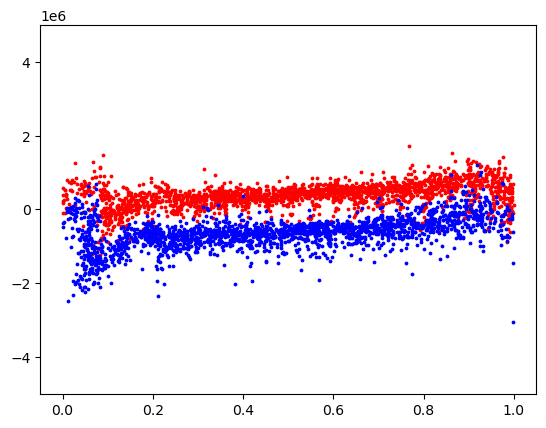

In [33]:
fig = plt.figure()
ax = plt.gca()
ax.set_ylim([-5e6,5e6])
function make_frame(i)
    plt.cla()
    ax.set_ylim([-5e6,5e6])
    firstx = historyxx[i+1][1:2:(size(historyxx[1])[1])]
    firstv = historyvel[i+1][1:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in firstx], [p[1] for p in firstv], s =3, color="red")
    secondx = historyxx[i+1][2:2:(size(historyxx[1])[1] )]
    secondv = historyvel[i+1][2:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in secondx], [p[1] for p in secondv], s =3, color="blue")
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(historyxx, 1), interval=100, blit=false)
myanim[:save]("tylkox2.gif", bitrate=-1)
